In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

## Pre-processing

In [11]:
#Load data files
takehome_users = pd.read_csv('takehome_users.csv', index_col = 0, encoding = "ISO-8859-1")
takehome_user_engagement = pd.read_csv('takehome_user_engagement.csv', index_col = 0, encoding = "ISO-8859-1")

In [12]:
#Encode Datetime columns
takehome_users.creation_time = pd.to_datetime(takehome_users.creation_time)
takehome_users.last_session_creation_time = pd.to_datetime(takehome_users.last_session_creation_time, unit = 's')

In [13]:
#Convert Index to Datetime
takehome_user_engagement.index = pd.to_datetime(takehome_user_engagement.index)

In [14]:
takehome_user_engagement.shape

(207917, 2)

In [15]:
takehome_users.shape

(12000, 9)

In [16]:
#Create features for days_since_session and account_age. 
#Assuption made that the latest date in the dataset is the reference point for both features
takehome_users['days_since_session'] = (takehome_users.last_session_creation_time.max() - 
                                        takehome_users.last_session_creation_time).dt.days
takehome_users['account_age'] = (takehome_users.last_session_creation_time.max() - 
                                        takehome_users.creation_time).dt.days

In [17]:
#Rolling sum calculation to cont the amount of visits a usser had made in a 7 day window
rs7 = takehome_user_engagement.groupby('user_id').rolling('7D').sum()

In [18]:
#Get users that have vistied 3 times in a 7 day window at least once. These are adopted users
adopted_users = np.unique(rs7[rs7['visited'] >= 3].index.get_level_values(0))

In [19]:
#Create labels for adopted users
takehome_users.loc[takehome_users.invited_by_user_id.notnull(),'invited'] = 1
takehome_users.invited = takehome_users.invited.fillna(0)

In [20]:
takehome_users.loc[adopted_users,'adopted'] = 1
takehome_users.adopted = takehome_users.adopted.fillna(0)

In [104]:
#Create feature dataset. All null values are discarded
feature_cols = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
               'days_since_session', 'account_age']
features = takehome_users.loc[:,feature_cols].dropna()

In [117]:
features.shape

(8823, 5)

In [106]:
#Processing
scaler = StandardScaler()
enc = OneHotEncoder(drop = 'first')
transformer = ColumnTransformer(transformers = [('scaler', scaler, ['account_age', 'days_since_session']),
                                                ('onehot',enc, ['creation_source'])],
                               remainder = 'passthrough', sparse_threshold = 0)
features_processed = transformer.fit_transform(features)

## Logistic Regression Model and Results

In [107]:
X = features_processed
y = takehome_users.loc[features.index,'adopted'].astype('int64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.8, random_state = 7)

In [108]:
lgr = LogisticRegressionCV(cv = 5, random_state = 7, max_iter = 1000)
_ = lgr.fit(X_train, y_train)

In [109]:
print("Logistic Regression Test Set Accuracy =", lgr.score(X_test,y_test))

Logistic Regression Test Set Accuracy = 0.9641592293525996


In [110]:
pred = lgr.predict(X_test)

In [123]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, filename = 'confusion_matrix.jpg'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig(filename)
    return ax

Normalized confusion matrix
[[0.99241118 0.00758882]
 [0.16574148 0.83425852]]


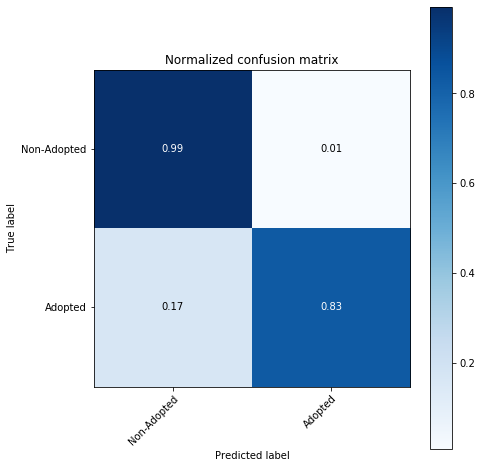

In [124]:
plot_confusion_matrix(y_test, pred,normalize=True, classes = ['Non-Adopted','Adopted'])

In [99]:
onehot_features = transformer.named_transformers_['onehot'].get_feature_names()

In [113]:
procesed_feature_names = ['account_age','days_since_session'] + list(onehot_features) + ['opted_in_to_mailing_list', 
                                                                                         'enabled_for_marketing_drip']

In [114]:
model_coef = pd.DataFrame(lgr.coef_.T, index = procesed_feature_names, columns = ['coef']).sort_values('coef')

In [115]:
model_coef_max_abs = abs(model_coef).sort_values('coef', ascending = False)

In [116]:
model_coef_max_abs

,coef
days_since_session,9.914559
account_age,8.996095
x0_SIGNUP_GOOGLE_AUTH,0.343943
x0_SIGNUP,0.317670
opted_in_to_mailing_list,0.222040
enabled_for_marketing_drip,0.219706
x0_ORG_INVITE,0.199462
x0_PERSONAL_PROJECTS,0.122942


In [119]:
model_coef

,coef
days_since_session,-9.914559
x0_SIGNUP_GOOGLE_AUTH,-0.343943
enabled_for_marketing_drip,-0.219706
x0_PERSONAL_PROJECTS,-0.122942
x0_ORG_INVITE,0.199462
opted_in_to_mailing_list,0.222040
x0_SIGNUP,0.317670
account_age,8.996095
